In [0]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  COLAB = True
  print(f"Running from google colab")
  %tensorflow_version 2.x
except:
  COLAB = False
  print(f"Not running from google colab")


In [6]:
#downloading data from Kaggle

!kaggle datasets download -d gasgallo/faces-data-new

 97% 87.0M/89.9M [00:01<00:00, 63.6MB/s]
100% 89.9M/89.9M [00:01<00:00, 88.4MB/s]


In [0]:
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json /root/.kaggle/.


In [7]:
#downloading data from Kaggle
!kaggle datasets download -d gasgallo/faces-data-new

faces-data-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip -d faces-data-new -q faces-data-new.zip

Using TensorFlow backend.


Will generate 84px square images.
Build Discriminator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 42, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 42, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 22, 22, 64)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 22, 22, 64)        0         
_________________________________________________________________
dr

  1%|          | 50/7865 [00:00<00:15, 493.05it/s]

Build Combined Model
Looking for file: faces-data-new/training_data_84_84.npy
Loading training images...


100%|██████████| 7865/7865 [00:12<00:00, 654.07it/s]


training_data.shape: (7864, 84, 84, 3)
Saving training image binary...
Image preprocess time: 0:00:14.12
x_train.shape (7864, 84, 84, 3)
epoch 0: [D loss: 0.696271, acc.: 37.50%] [G loss: 0.795267, acc.: 0.00%] elapsed time [0:00:08.42]
epoch 100: [D loss: 0.544215, acc.: 71.88%] [G loss: 0.518802, acc.: 90.62%] elapsed time [0:00:00.07]
epoch 200: [D loss: 0.287138, acc.: 96.88%] [G loss: 0.325840, acc.: 100.00%] elapsed time [0:00:00.08]
epoch 300: [D loss: 0.433107, acc.: 92.19%] [G loss: 1.244574, acc.: 0.00%] elapsed time [0:00:00.08]
epoch 400: [D loss: 0.610844, acc.: 65.62%] [G loss: 0.973664, acc.: 12.50%] elapsed time [0:00:00.08]
epoch 500: [D loss: 0.561335, acc.: 82.81%] [G loss: 0.937841, acc.: 31.25%] elapsed time [0:00:00.08]
epoch 600: [D loss: 0.541663, acc.: 75.00%] [G loss: 0.724343, acc.: 56.25%] elapsed time [0:00:00.08]
epoch 700: [D loss: 0.676401, acc.: 64.06%] [G loss: 0.521737, acc.: 78.12%] elapsed time [0:00:00.07]
epoch 800: [D loss: 0.620806, acc.: 64.06%

KeyboardInterrupt: ignored

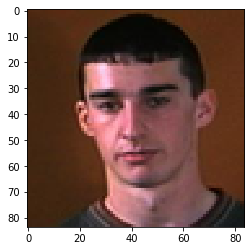

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.datasets import fashion_mnist, mnist
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

class DCGAN_FACES:

	def __init__(self, rows=28, cols=28, channels=3, generator_resolution=1):
	
		# Generation resolution - Must be square 
		# Training data is also scaled to this.
		# Note GENERATE_RES 4 or higher  will blow Google CoLab's memory and have not
		# been tested extensivly.
		self.GENERATE_RES = generator_resolution # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
		self.GENERATE_SQUARE = rows * self.GENERATE_RES # rows/cols (should be square)
		self.IMAGE_CHANNELS = channels
		
		# Preview image 
		self.PREVIEW_ROWS = 4
		self.PREVIEW_COLS = 7
		self.PREVIEW_MARGIN = 16
		
		# Size vector to generate images from
		self.latent_dim = 100
		
		# Configuration
		#DATA_PATH = '/content/drive/My Drive/projects/faces'
		#self.DATA_PATH = '/content/gdrive/My Drive/MLProjects/GAN/kaggle-faces-keras'
		self.DATA_PATH = 'faces-data-new'
		#self.EPOCHS = 50
		#BATCH_SIZE = 32
		#BUFFER_SIZE = 60000
		
		print(f"Will generate {self.GENERATE_SQUARE}px square images.")
	
		self.rows = rows
		self.cols = cols
		self.channels = channels
		self.image_shape = (self.rows*self.GENERATE_RES, self.cols*self.GENERATE_RES, self.channels)
		self.latent_dim = 100
		self.sample_rows = 5
		self.sample_cols = 5
		self.sample_path = 'images'

		optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
		
		generator_optimizer = Adam(1.5e-4,0.5)
		discriminator_optimizer = Adam(1.5e-4,0.5)
		
		# This method returns a helper function to compute cross entropy loss
		cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
		
		#Get the discriminator and generator Models
		print("Build Discriminator")
		self.discriminator = self.build_discriminator()
		
		self.discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])
  
		print("Build Generator")
		
		self.generator = self.build_generator()
		
		random_input = Input(shape=(self.latent_dim,))
		generated_image = self.generator(random_input)
		
		self.discriminator.trainable = False
		validity = self.discriminator(generated_image)
		
		print("Build Combined Model")
		self.combined_model = Model(random_input, validity)
		self.combined_model.compile(loss='binary_crossentropy', optimizer=generator_optimizer,metrics=['accuracy'])

	# Nicely formatted time string
	def hms_string(self,sec_elapsed):
		h = int(sec_elapsed / (60 * 60))
		m = int((sec_elapsed % (60 * 60)) / 60)
		s = sec_elapsed % 60
		return "{}:{:>02}:{:>05.2f}".format(h, m, s)


	def build_generator(self): #DCGAN - Faces
		model = Sequential()
		
		print("Before Dense")
		model.add(Dense(7*7*256,activation="relu",input_dim=self.latent_dim, name='Gen_dense_1'))
		model.add(Reshape((7,7,256)))
		model.add(UpSampling2D())
		
		model.add(Conv2D(128,kernel_size=3,padding="same"))
		model.add(BatchNormalization(momentum=0.8))
		model.add(Activation("relu"))
		
		model.add(UpSampling2D())
		model.add(Conv2D(64,kernel_size=3,padding="same"))
		model.add(BatchNormalization(momentum=0.8))
		model.add(Activation("relu"))
		
		# Output resolution, additional upsamplingDATA_PATH'
		#model.add(UpSampling2D())
		#model.add(Conv2D(128,kernel_size=3,padding="same"))
		#model.add(BatchNormalization(momentum=0.8))
		#model.add(Activation("relu"))
		
		if self.GENERATE_RES>1:
			model.add(UpSampling2D(size=(self.GENERATE_RES,self.GENERATE_RES)))
			model.add(Conv2D(128,kernel_size=3,padding="same"))
			model.add(BatchNormalization(momentum=0.8))
			model.add(Activation("relu"))
		
		# Final CNN layer
		model.add(Conv2D(self.channels,kernel_size=3,padding="same"))
		#model.add(Activation("tanh"))
		model.add(Activation("sigmoid"))
	
		model.summary()
	
		return model


	def build_discriminator(self): #DCGAN - Faces
		model = Sequential()
		
		model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))
		
		model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
		model.add(ZeroPadding2D(padding=((0,1),(0,1))))
		#model.add(BatchNormalization(momentum=0.8))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
		#model.add(BatchNormalization(momentum=0.8))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
		#model.add(BatchNormalization(momentum=0.8))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
		#model.add(BatchNormalization(momentum=0.8))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Flatten())
		model.add(Dense(1, activation='sigmoid',name = 'Des_Dense_1'))
	
		model.summary()
		
		return model

	def build_discriminator1(self): #GAN
	
		def conv_block(x,filter_size,strides=2, padding='same' ):
			x = Conv2D(filter_size, (3,3), strides = strides, padding = padding)(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = Dropout(0.3)(x)
			return x
		
		input_shape = (self.rows, self.cols, self.channels)
		
		input_image = Input(shape=input_shape)
		
		x = conv_block(input_image, 64, strides=(2,2))
		x = conv_block(x, 128, strides=(1,1))
		x = conv_block(x,256, strides=(2,2))
		x = conv_block(x,512, (1,1))
		
		features = Flatten()(x)
		real_or_fake = Dense(1, activation='sigmoid')(features)
		
		
		return Model(input_image,real_or_fake)

	def build_generator1(self): #GAN
	
	
		
		model = Sequential()
		model.add(Dense(7*7*256, input_dim=self.latent_dim))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Reshape((7,7,256)))
		model.add(Dropout(0.4))
		
		model.add(Conv2DTranspose(128,(5,5),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(64,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(32,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Conv2DTranspose(1,(3,3),padding='same'))
		model.add(Activation('sigmoid'))
		
		input = Input(shape=(self.latent_dim,))
		
		generated_image = model(input)
		
		#model.summary()
		
		return(Model(input,generated_image))
		
		
	def save_images(self,cnt,noise):
		image_array = np.full(( 
			self.PREVIEW_MARGIN + (self.PREVIEW_ROWS * (self.GENERATE_SQUARE+self.PREVIEW_MARGIN)), 
			self.PREVIEW_MARGIN + (self.PREVIEW_COLS * (self.GENERATE_SQUARE+self.PREVIEW_MARGIN)), 3), 
			255, dtype=np.uint8)
		
		generated_images = self.generator.predict(noise)
		
		generated_images = 0.5 * generated_images + 0.5
		
		image_count = 0
		for row in range(self.PREVIEW_ROWS):
			for col in range(self.PREVIEW_COLS):
				r = row * (self.GENERATE_SQUARE+16) + self.PREVIEW_MARGIN
				c = col * (self.GENERATE_SQUARE+16) + self.PREVIEW_MARGIN
				image_array[r:r+self.GENERATE_SQUARE,c:c+self.GENERATE_SQUARE] = generated_images[image_count] * 255
				image_count += 1

          
		output_path = os.path.join(self.DATA_PATH,'output')
		if not os.path.exists(output_path):
		  os.makedirs(output_path)
  
		filename = os.path.join(output_path,"train-{:06d}.png".format(cnt))
		im = Image.fromarray(image_array)
		im.save(filename)


	def plot_sample_images(self, epoch, noise):
		r, c = self.sample_rows, self.sample_cols
		
		gen_imgs = self.generator.predict(noise)
		
		filename = os.path.join(self.sample_path,'%d.png'% epoch)
		fig, axs = plt.subplots(r, c)
		cnt = 0
		for i in range(r):
			for j in range(c):
				axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
				axs[i,j].axis('off')
				cnt += 1
		fig.savefig(filename)
		plt.close()
	

	def load_faces(self):
		# Image set has 11,682 images.  Can take over an hour for initial preprocessing.
		# Because of this time needed, save a Numpy preprocessed file.
		# Note, that file is large enough to cause problems for sume verisons of Pickle,
		# so Numpy binary files are used.
		training_binary_path = os.path.join(self.DATA_PATH,f'training_data_{self.GENERATE_SQUARE}_{self.GENERATE_SQUARE}.npy')

		print(f"Looking for file: {training_binary_path}")

		start = time.time()

		if not os.path.isfile(training_binary_path):
			#start = time.time()
			print("Loading training images...")

			training_data = []
			#faces_path = os.path.join(DATA_PATH,'face_images')
			faces_path = os.path.join(self.DATA_PATH,'images')
			for filename in tqdm(os.listdir(faces_path)):
				path = os.path.join(faces_path,filename)
				if os.path.isfile(path):
					image = Image.open(path).resize((self.GENERATE_SQUARE,self.GENERATE_SQUARE),Image.ANTIALIAS)
					training_data.append(np.asarray(image))
			training_data = np.reshape(training_data,(-1,self.GENERATE_SQUARE,self.GENERATE_SQUARE,self.IMAGE_CHANNELS))
			training_data = training_data.astype(np.float32)
			#training_data = training_data / 127.5 - 1.
			#training_data = training_data / 255.
			print(f'training_data.shape: {training_data.shape}')


			print("Saving training image binary...")
			np.save(training_binary_path,training_data)
			elapsed = time.time()-start
			print (f'Image preprocess time: {self.hms_string(elapsed)}')
		else:
			print("Loading previous training numpy...")
			training_data = np.load(training_binary_path)

		return training_data

	def plot_loss(self,losses):
		"""
		@losses.keys():
			0: loss
			1: accuracy
		"""
		d_loss = [v[0] for v in losses["D"]]
		g_loss = [v[0] for v in losses["G"]]
		
		plt.figure(figsize=(10,8))
		plt.plot(d_loss, label="Discriminator loss")
		plt.plot(g_loss, label="Generator loss")
		
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()


		
	def train(self, epochs=10000, batch_size=32, save_freq=200):
		
		#Load Dataset
		#(x_train,_),(_,_) = mnist.load_data()
		
		x_train = self.load_faces()
		
		
		#(x_train,_),(_,_) = fashion_mnist.load_data()
		
		#normalize and reset train set in range (0,1) # normalizing to (-1,1) seems to be not working.
		
		#x_train = np.expand_dims(x_train, axis=-1)
		
		#x_train = (x_train.astype('float32') / 127.5 ) - 1. # Normalizing this way doesn't work during training.
		#x_train = (x_train / 127.5 ) - 1.
		
		x_train = x_train.astype('float32')/255.0 #Normalizing  this way does work during training.
		
		
		print("x_train.shape",x_train.shape)
	
		plt.imshow(x_train[0])
		
		#Ground Truth. Setting real images labels to True
		y_real = np.ones((batch_size,1))
		
		#Setting fake images labels to False
		y_fake = np.zeros((batch_size,1))
		
		
		#fixed_seed = np.random.normal(0,1,size=[25,self.latent_dim])
		
		cnt = 1
		
		#Generating Fixed noise to be passed for sampling with same inputs after set of epochs and seeing the results
		#noise_input = np.random.normal(0,1,size=[self.sample_rows*self.sample_cols,self.latent_dim])
		fixed_seed = np.random.normal(0, 1, (self.PREVIEW_ROWS * self.PREVIEW_COLS, self.latent_dim))
		start = time.time()
		
		#Setup loss vector to store losses for Generator and Discriminator
		
		losses = {"D":[], "G":[]}
		
		path = self.sample_path
		if not os.path.isdir(path):
		  os.mkdir(path)
		
		for epoch in range(epochs):
		
			epoch_start = time.time()
			#Training of Discriminator. Taking random samples of batch_size #
			noise = np.random.normal(0,1,size=[batch_size,self.latent_dim])
			
			#take random batched of indexes for x_train
			idx = np.random.randint(0,x_train.shape[0],size=batch_size)
			
			#print(idx[0:10])
			x_real = x_train[idx]
			
			#print("x_real.shape",x_real.shape)
			
			#Generate some fake images
			x_fake = self.generator.predict(noise)
				
			x = np.concatenate((x_real,x_fake))
			
			y = np.ones([2*batch_size,1])
			y[batch_size:,:] = 0
			
			#Train discriminator on real and fake
			d_loss = self.discriminator.train_on_batch(x,y)
			
			#Train Generator on Calculated loss
			y = np.ones([batch_size, 1])
				
			#noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_dim])
			noise = np.random.normal(0,1,size=[batch_size,self.latent_dim])
			
			g_loss = self.combined_model.train_on_batch(noise,y)
			
			losses["D"].append(d_loss)
			losses["G"].append(g_loss)
			
			
			
			
			#Time for an update
			
			if save_freq > 0:
				if epoch % save_freq == 0:
					
					epoch_elapsed = time.time()-epoch_start
					#print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {self.hms_string(epoch_elapsed)}')
					print ("epoch %d: [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%] elapsed time [%s]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1], self.hms_string(epoch_elapsed)))
				
					#self.plot_sample_images(epoch, fixed_seed)
					self.save_images(epoch,fixed_seed)
					cnt+=1
		elapsed = time.time()-start
		print (f'Training time: {self.hms_string(elapsed)}')
					
		self.plot_loss(losses)
		
if __name__ == '__main__':
	generator_resolution = 3
	rows=28
	cols=28
	channels=3
	
	gan = DCGAN_FACES(rows=rows, cols=cols, channels=channels,generator_resolution=generator_resolution)
	#gan.train(epochs=14000, batch_size=32, save_freq=200)		
	gan.train(epochs=50000,batch_size=32,save_freq=100)

In [0]:
#!rm -r images/*
#!rm -r faces-data-new/output/*
#!rm -r gdrive/My\ Drive/MLProjects/GAN/kaggle-faces-keras/output/*


rm: cannot remove 'images/*': No such file or directory


In [0]:
import imageio
images = []
faces_path  = os.path.join("faces-data-new","output")
for filename in sorted(os.listdir(faces_path)):
  file = os.path.join(faces_path,filename)
  print(filename)
  images.append(imageio.imread(file))
imageio.mimsave('gan_faces_movie3.gif', images,duration = 0.5)

In [0]:
!cp gan_faces_movie3.gif gdrive/My\ Drive/MLProjects/.